### HAR 데이터 읽기

In [1]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
X_train = pd.read_csv('HAR_dataset/train/X_train.txt',sep='\s+', header=None)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB


In [2]:
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'


X_test = pd.read_csv('HAR_dataset/test/X_test.txt', sep='\s+', header=None)

In [3]:
y_train_url ='https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
y_train_url ='https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv('HAR_dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
y_test = pd.read_csv("HAR_dataset/test/y_test.txt", sep='\s+', header=None, names=['action'])

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

### 재사용을 위해 학습 함수를 만들어준다.

In [5]:
from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)
    
    return pca.transform(ss_data), pca


### PCA fit

In [6]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pca.shape

(7352, 2)

In [7]:
pca.mean_.shape, pca.components_.shape

((561,), (2, 561))

In [8]:
cols = ['pca_'+str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

### PCA 결과를 저장하는 함수

In [9]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

### 주성분 2개

In [10]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()


,pca_0,pca_1,action
0,-5.520280,-0.290278,5
1,-5.535350,-0.082531,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


### 주성분 2개로 표현하는것이 좋아 보이지는 않는다...

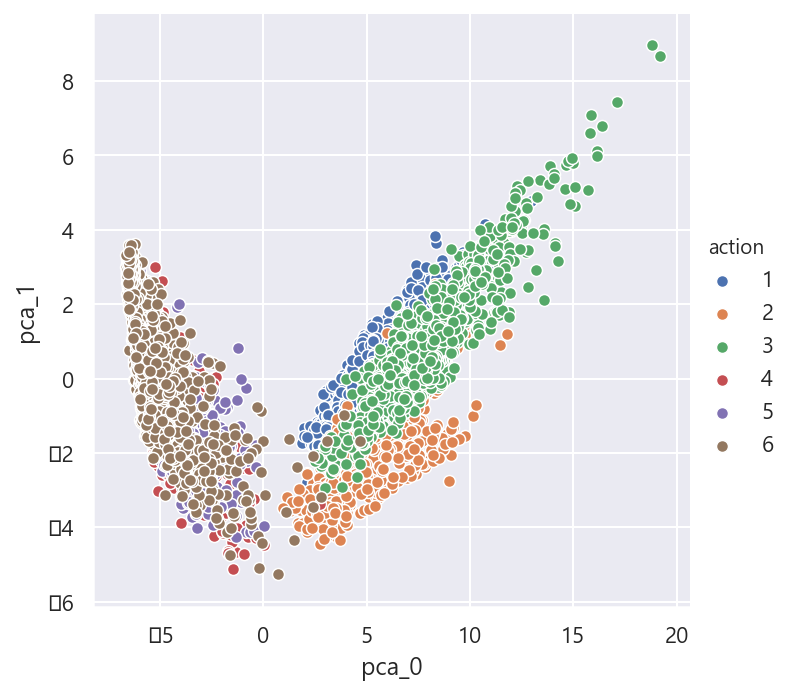

In [11]:
import seaborn as sns

sns.pairplot(HAR_pd_pca, hue='action', height=5, x_vars=['pca_0'], y_vars=['pca_1'])

### 전체 500개가 넘는 특성을 단 두개로 줄이면 67%w정도 표현이 된다.

In [12]:
import numpy as np

def print_variance_ratio(pca):
    print('variance_ratio : ', pca.explained_variance_ratio_)
    print('sum of variance_ratio : ', np.sum(pca.explained_variance_ratio_))
    

print_variance_ratio(pca)


variance_ratio :  [0.6255444  0.04913023]
sum of variance_ratio :  0.6746746270487657


### 주성분 3개 약 71%표현이 가능하다

In [13]:
HAR_pca, pca = get_pca_data(X_train, n_components=3)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023 0.04121467]
sum of variance_ratio :  0.7158893015785998


### 주성분 10개 80% 표현이 가능하다

In [14]:
HAR_pca, pca = get_pca_data(X_train, n_components=10)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio :  [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.00969377 0.00858017]
sum of variance_ratio :  0.8050386795776512


### 이 결과가 시간이 길게 나왔다면 지금은?

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


params = {
    'max_depth' : [6, 8 , 10],
    'n_estimators' : [50, 100, 200],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(HAR_pca, y_train.values.reshape(-1,))

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=13,
                                    

### 성능은 조금 나빠졌다

In [16]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
35,1,0.838547,200,10
32,1,0.838547,200,10
14,3,0.838275,200,8
17,3,0.838275,200,8
2,5,0.836915,200,6


### bset 파라미터

In [17]:
grid_cv.best_params_

{'max_depth': 10,
 'min_samples_leaf': 12,
 'min_samples_split': 8,
 'n_estimators': 200}

In [18]:
grid_cv.best_score_

0.8385473340587595

### 테스트 데이터에 적용해보자

In [19]:
from sklearn.metrics import accuracy_score


rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(HAR_pca, y_train.values.reshape(-1,))

pred1 = rf_clf_best.predict(pca.transform(X_test))

accuracy_score(y_test, pred1)


0.8520529351883271

### 시간이 많이 걸렸던 xgboost는?
    - 시간과 성능의 trade-off가 필요하다면 사용하면 좋을듯 하다

In [20]:
import time
from xgboost import XGBClassifier

evals = [(pca.transform(X_test), y_test)]

start_time = time.time()
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(HAR_pca, y_train.values.reshape(-1,),
       early_stopping_rounds=10, eval_set=evals)
print('Fit time : ', time.time()  - start_time)



[0]	validation_0-merror:0.22531
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.22192
[2]	validation_0-merror:0.20461
[3]	validation_0-merror:0.20428
[4]	validation_0-merror:0.20156
[5]	validation_0-merror:0.20258
[6]	validation_0-merror:0.19715
[7]	validation_0-merror:0.19511
[8]	validation_0-merror:0.19511
[9]	validation_0-merror:0.19172
[10]	validation_0-merror:0.18901
[11]	validation_0-merror:0.18595
[12]	validation_0-merror:0.18765
[13]	validation_0-merror:0.18629
[14]	validation_0-merror:0.18256
[15]	validation_0-merror:0.18052
[16]	validation_0-merror:0.18052
[17]	validation_0-merror:0.17883
[18]	validation_0-merror:0.17611
[19]	validation_0-merror:0.17679
[20]	validation_0-merror:0.17781
[21]	validation_0-merror:0.17577
[22]	validation_0-merror:0.17441
[23]	validation_0-merror:0.17509
[24]	validation_0-merror:0.17577
[25]	validation_0-merror:0.17408
[26]	validation_0-merror:0.17340
[27]	validation_0-merror:0.17374
[28]	validation_0-m

### accuracy

In [21]:
accuracy_score(y_test, xgb.predict(pca.transform(X_test)))

0.8591788259246692